In [43]:
import geopandas as gpd
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import rasterio
import rioxarray as rxr
from shapely.geometry import *

In [121]:
gfc = rxr.open_rasterio("../data/global_forest_change_2023_v1_11.tif")
tree_cover = rxr.open_rasterio("../data/Percent_Tree_Cover.tif")
bfm = rxr.open_rasterio("../../R/renv/data/bfm_first.tif")

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [122]:
aoi = gpd.read_file("../data/adm_2/lao_admbnda_adm2_ngd_20191112.shp").explode()
aoi_geometry = aoi[aoi["ADM2_EN"] == "Chomphet"]["geometry"].iloc[0]

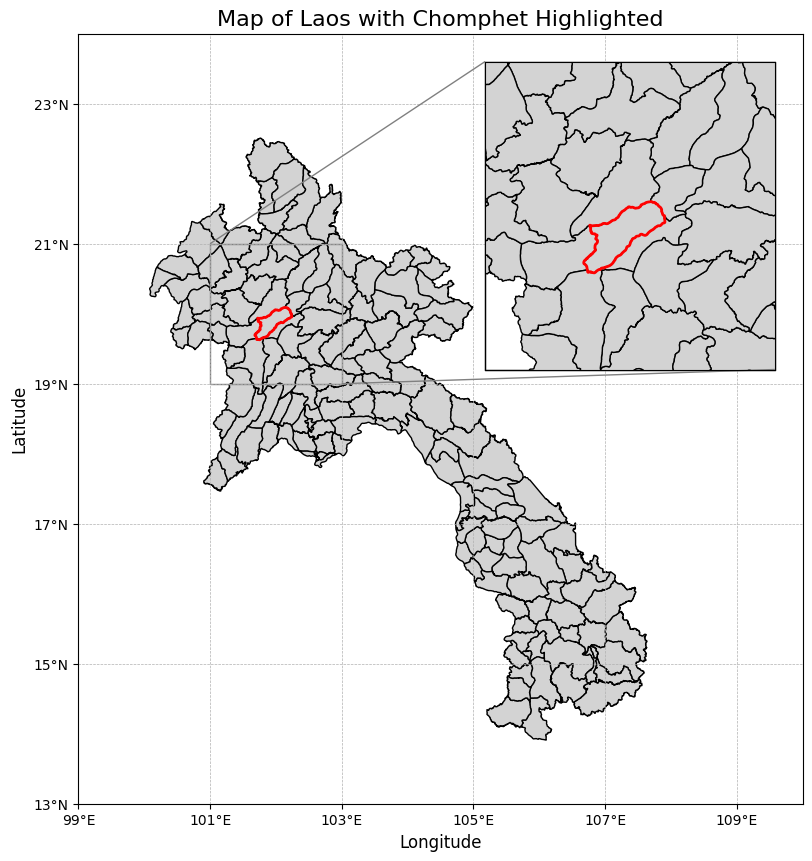

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

aoi.plot(ax=ax, edgecolor="black", color="lightgray")

chomphet.boundary.plot(ax=ax, edgecolor="red", linewidth=2)

ax.set_title("Map of Laos with Chomphet Highlighted", fontsize=16)

ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

ax.grid(True, which="both", linestyle="--", linewidth=0.5)


xmin, xmax = 99, 110
ymin, ymax = 13, 24
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_xticks(range(xmin, xmax + 1, 2))
ax.set_yticks(range(ymin, ymax + 1, 2))

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{x}°E"))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f"{y}°N"))

ax_inset = inset_axes(ax, width="40%", height="40%", loc="upper right", borderpad=2)

aoi.plot(ax=ax_inset, edgecolor="black", color="lightgray")
chomphet.boundary.plot(ax=ax_inset, edgecolor="red", linewidth=2)

inset_xmin, inset_xmax = 101, 103
inset_ymin, inset_ymax = 19, 21
ax_inset.set_xlim(inset_xmin, inset_xmax)
ax_inset.set_ylim(inset_ymin, inset_ymax)

ax_inset.set_xticks([])
ax_inset.set_yticks([])

ax_inset.patch.set_edgecolor("black")
ax_inset.patch.set_linewidth(1)

mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()

In [123]:
def clip_and_analyze(data, aoi_geometry):
    clipped_data = data.rio.clip([aoi_geometry], drop=True)
    return clipped_data

bfm_clipped = clip_and_analyze(bfm, aoi_geometry)
tree_cover_clipped = clip_and_analyze(tree_cover, aoi_geometry)
gfc_clipped = clip_and_analyze(gfc, aoi_geometry)

In [124]:
# Create forest loss mask from BFM and tree cover data (250m resolution)
def create_bfm_mask(bfm, tree_cover):
    magnitude = bfm[1].values
    tree_cover_values = tree_cover[0].values

    bfm_forest_loss = np.zeros_like(magnitude)
    bfm_forest_loss[(magnitude <= -0.05) & (tree_cover_values >= 30)] = 1

    return bfm_forest_loss


# Create forest loss mask from GFC data (30m resolution)
def create_gfc_mask(gfc):
    lossyear = gfc[1].values
    gfc_loss = np.zeros_like(lossyear)
    gfc_loss[lossyear >= 20] = 1  # Values >= 10 indicate forest loss after 2010

    return gfc_loss

In [125]:
extent_bfm = [
    bfm_clipped.rio.bounds()[0],  # left
    bfm_clipped.rio.bounds()[2],  # right
    bfm_clipped.rio.bounds()[1],  # bottom
    bfm_clipped.rio.bounds()[3],  # top
]

extent_gfc = [
    gfc_clipped.rio.bounds()[0],  # left
    gfc_clipped.rio.bounds()[2],  # right
    gfc_clipped.rio.bounds()[1],  # bottom
    gfc_clipped.rio.bounds()[3],  # top
]


bfm_mask = create_bfm_mask(bfm_clipped, tree_cover_clipped)
gfc_mask = create_gfc_mask(gfc_clipped)

bfm_bounds_box = box(*bfm_clipped.rio.bounds())
aoi_clipped = aoi[aoi.intersects(bfm_bounds_box)]

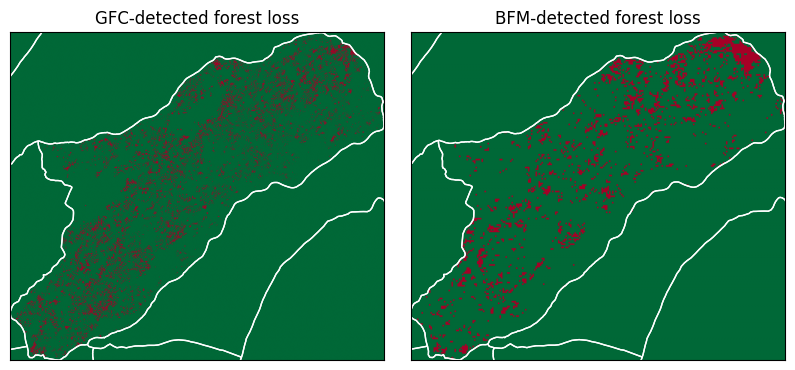

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

im1 = ax1.imshow(gfc_mask, cmap="RdYlGn_r", extent=extent_bfm)
aoi_clipped.boundary.plot(ax=ax1, edgecolor="white", linewidth=1)
ax1.set_title("GFC-detected forest loss")
ax1.set_xticks([])
ax1.set_yticks([])

im2 = ax2.imshow(bfm_mask, cmap="RdYlGn_r", extent=extent_gfc)
aoi_clipped.boundary.plot(ax=ax2, edgecolor="white", linewidth=1)
ax2.set_title("BFM-detected forest loss")
ax2.set_xticks([])
ax2.set_yticks([])

ax1.set_xlim(extent_bfm[0], extent_bfm[1])
ax1.set_ylim(extent_bfm[2], extent_bfm[3])

ax2.set_xlim(extent_gfc[0], extent_gfc[1])
ax2.set_ylim(extent_gfc[2], extent_gfc[3])

plt.subplots_adjust(wspace=0.07, hspace=0.1)
plt.show()

In [127]:
# Calculate areas (multiply pixel count by respective resolution squared)
bfm_area = np.sum(bfm_mask) * 0.25 * 0.25  # 250m resolution
gfc_area = np.sum(gfc_mask) * 0.03 * 0.03  # 30m resolution

print(f"Forest Loss Area Comparison:")
print(f"BFM-detected forest loss): {bfm_area:.2f} km²")
print(f"GFC-detected forest loss: {gfc_area:.2f} km²")

Forest Loss Area Comparison:
BFM-detected forest loss): 154.38 km²
GFC-detected forest loss: 137.87 km²


In [117]:
data_path = "../data/modis_images/"
files_2017 = (
    sorted(glob.glob(data_path + "2017-01-*.tif"))
    + sorted(glob.glob(data_path + "2017-02-*.tif"))
    + sorted(glob.glob(data_path + "2017-03-*.tif"))
)
files_2023 = (
    sorted(glob.glob(data_path + "2023-01-*.tif"))
    + sorted(glob.glob(data_path + "2023-02-*.tif"))
    + sorted(glob.glob(data_path + "2023-03-*.tif"))
)


def calculate_mean(files):
    data_stack = []
    for file in files:
        with rasterio.open(file) as src:
            data = src.read(1)
            data[data == src.nodata] = np.nan
            data_stack.append(data)
    return np.nanmean(data_stack, axis=0)



mean_evi_2017 = calculate_mean(files_2017)
mean_evi_2023 = calculate_mean(files_2023)


vmin = min(np.nanmin(mean_evi_2017), np.nanmin(mean_evi_2023))
vmax = max(np.nanmax(mean_evi_2017), np.nanmax(mean_evi_2023))

/var/folders/j3/w8ll30vx0q5fhcrw8rws373w0000gn/T/ipykernel_5708/3694097316.py:21: RuntimeWarning: Mean of empty slice
  return np.nanmean(data_stack, axis=0)


In [69]:
import numpy as np
import rasterio
from rasterio import windows
from rasterio.features import geometry_mask
from shapely.geometry import shape, box, mapping

target_geometry = {
    "type": "Polygon",
    "coordinates": [
        [
            [102.11460412173763, 20.089120624475097],
            [102.11460412173763, 20.002324528308712],
            [102.22025856335725, 20.002324528308712],
            [102.22025856335725, 20.089120624475097],
            [102.11460412173763, 20.089120624475097],
        ]
    ],
}

target_poly = shape(target_geometry)


def clip_array_by_geometry(data_array, transform, geometry):
    minx, miny, maxx, maxy = geometry.bounds

    window = windows.from_bounds(minx, miny, maxx, maxy, transform=transform)

    row_off = int(window.row_off)
    col_off = int(window.col_off)
    height = int(window.height)
    width = int(window.width)

    clipped_data = data_array[row_off : row_off + height, col_off : col_off + width]

    new_transform = windows.transform(window, transform)

    mask = geometry_mask(
        [mapping(geometry)],
        out_shape=clipped_data.shape,
        transform=new_transform,
        invert=True,
    )

    clipped_data[~mask] = np.nan

    return clipped_data, new_transform

In [119]:
from shapely.geometry import shape

target_poly = shape(target_geometry)


modis = rxr.open_rasterio(files_2017[0])
evi_2017_clipped, evi_2017_transform_clipped = clip_array_by_geometry(
    mean_evi_2017, modis.rio.transform(), target_poly
)

evi_2023_clipped, evi_2023_transform_clipped = clip_array_by_geometry(
    mean_evi_2023, modis.rio.transform(), target_poly
)

In [128]:
def create_bfm_mask_clipped(bfm, tree_cover, target_poly):
    bfm_clip = bfm.rio.clip([target_poly], drop=True)
    tree_cover_clip = tree_cover.rio.clip([target_poly], drop=True)

    magnitude = bfm_clip[1].values
    tree_cover_values = tree_cover_clip[0].values

    bfm_forest_loss = np.zeros_like(magnitude, dtype=np.float32)
    bfm_forest_loss[(magnitude <= -0.05) & (tree_cover_values >= 30)] = 1

    return bfm_forest_loss


def create_gfc_mask_clipped(gfc, target_poly):
    gfc_clip = gfc.rio.clip([target_poly], drop=True)

    lossyear = gfc_clip[1].values

    gfc_loss = np.zeros_like(lossyear, dtype=np.float32)
    gfc_loss[lossyear >= 20] = 1

    return gfc_loss

In [129]:
bfm_mask_clipped = create_bfm_mask_clipped(bfm_clipped, tree_cover_clipped, target_poly)
gfc_mask_clipped = create_gfc_mask_clipped(gfc_clipped, target_poly)

/var/folders/j3/w8ll30vx0q5fhcrw8rws373w0000gn/T/ipykernel_5708/2307302969.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 1])


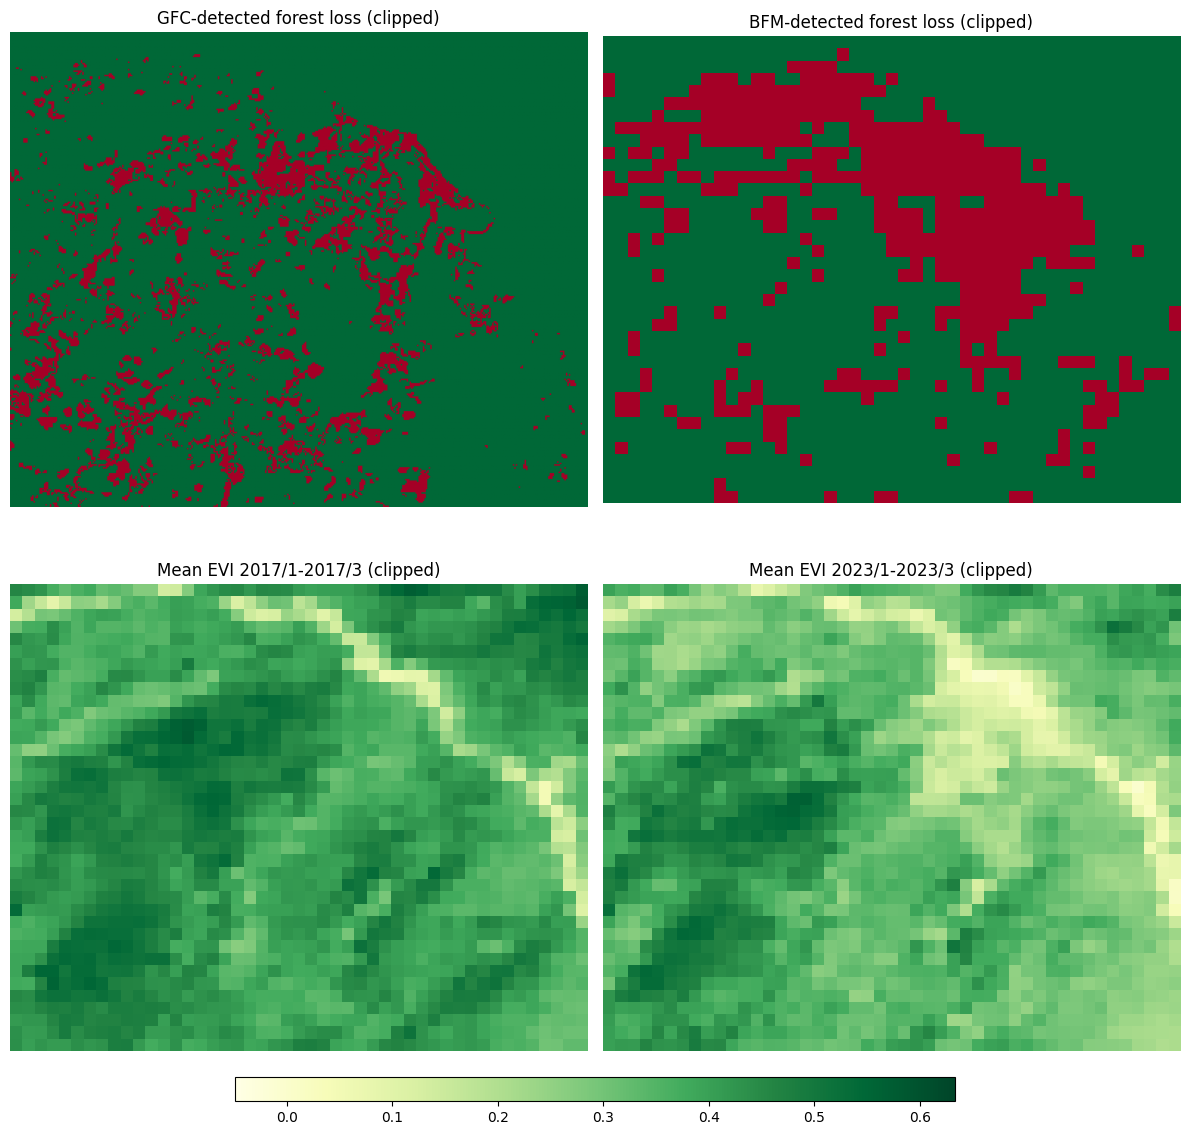

In [130]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

im1 = axes[0, 0].imshow(gfc_mask_clipped, cmap="RdYlGn_r")
axes[0, 0].set_title("GFC-detected forest loss (clipped)")
axes[0, 0].axis("off")

im2 = axes[0, 1].imshow(bfm_mask_clipped, cmap="RdYlGn_r")
axes[0, 1].set_title("BFM-detected forest loss (clipped)")
axes[0, 1].axis("off")

im3 = axes[1, 0].imshow(evi_2017_clipped, cmap="YlGn", vmin=vmin, vmax=vmax)
axes[1, 0].set_title("Mean EVI 2017/1-2017/3 (clipped)")
axes[1, 0].axis("off")

im4 = axes[1, 1].imshow(evi_2023_clipped, cmap="YlGn", vmin=vmin, vmax=vmax)
axes[1, 1].set_title("Mean EVI 2023/1-2023/3 (clipped)")
axes[1, 1].axis("off")

cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])
fig.colorbar(im3, cax=cbar_ax, orientation="horizontal")

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()